## Unsupervised BGM and soft voting for initial labelling (Score ~ 60.7%)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import PowerTransformer
import pylab as pl
from sklego.mixture import BayesianGMMClassifier

In [3]:
n_rows = 98000
n_clusters = 7

known = pd.read_csv("reference_submission.csv", index_col=0).iloc[:, 0].values

data = pd.read_csv('data.csv', index_col=0)
useful_cols = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13',
             'f_22','f_23','f_24','f_25','f_26','f_27','f_28']
data = data[useful_cols]

data = PowerTransformer().fit_transform(data)

In [3]:
all_labels = []
all_probs = []

base = 1301
for seed in tqdm(range(20)):
    np.random.seed(seed + base * 20)
    subspace = data[np.random.random(size=(n_rows,)) < 0.5, :]
 
    gmm = BayesianGaussianMixture(
            n_components = n_clusters,
            random_state = seed + base * 20,
            tol = 0.001,  # Actually, since we're ensembling we might want a higher tol
            max_iter = 200, # and a low max_iter! Because noise is our friend.
            n_init = 4)
    gmm.fit(subspace)

    all_labels.append(gmm.predict(data))
    all_probs.append(gmm.predict_proba(data))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:07<00:00, 33.35s/it]


In [4]:
hard_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.int32)
soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)
soft_soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)

for model_i, labels in enumerate(all_labels):
    probs = all_probs[model_i]
    
    # We create a small n_cluster x n_cluster matrix to store which
    # cluster corresponds to which, compared to the known good clustering.
    clusters = np.zeros(shape = (n_clusters, n_clusters), dtype=int)
    for n1, n2 in zip(labels, known):
        clusters[n1, n2] += 1

    hard_clusters = np.argmax(clusters, axis=1)
    hard_dict = {i: c for i, c in enumerate(hard_clusters)}
    hard_result = np.vectorize(hard_dict.__getitem__)(labels)
    hard_accumulator[np.arange(n_rows), hard_result] += 1
    
    # soft
    soft_clusters = clusters / np.sum(clusters, axis=1).reshape(-1, 1)
    soft_result = soft_clusters[labels]
    soft_accumulator += soft_clusters[labels]

    # extra soft
    soft_soft_accumulator += np.matmul(probs, soft_clusters)

In [5]:
# hard_result = np.argmax(hard_accumulator, axis=1)
# soft_result = np.argmax(soft_accumulator, axis=1)
soft_soft_result = np.argmax(soft_soft_accumulator, axis=1)

pd.DataFrame(soft_soft_result).to_csv('bgm_unsupervised_submission.csv', index_label='Id', header=['Predicted'])

## Supervised BGM classifier using the best predictions

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import BayesianGaussianMixture
from sklego.mixture import BayesianGMMClassifier
from sklearn.preprocessing import PowerTransformer

In [11]:
data = pd.read_csv("data.csv", index_col='id')
submission = pd.read_csv("sample_submission.csv")

pred_test = pd.read_csv("bgm_unsupervised_submission.csv", usecols=['Predicted']).values
pred_test = [a.item() for a in pred_test]
pred_test = np.array(pred_test)

known = pd.read_csv("bgm_supervised_classifier.csv", usecols=['Predicted']).values

useful_cols = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13',
             'f_22','f_23','f_24','f_25','f_26','f_27','f_28']

data = data[useful_cols]
data = PowerTransformer().fit_transform(data)

In [4]:
X = np.array(data)
y = np.array(pred_test)

In [ ]:
all_labels = []
all_probs = []

for seed in tqdm(range(20)):
    np.random.seed(seed + 1001 * 20)
    bgm = BayesianGMMClassifier(
        n_components=7,
        random_state = seed,
        tol =1e-3,
        covariance_type = 'full',
        max_iter = 200,
        n_init=3,
        init_params='k-means++'
    )

    # fitting and probability prediction
    bgm.fit(X,y)
    all_labels.append(bgm.predict(X))
    all_probs.append(bgm.predict_proba(X))

 20%|█████████████████████                                                                                    | 4/20 [03:12<12:41, 47.57s/it]C:\Users\Alessandro\anaconda3\envs\unsupervised\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 40%|██████████████████████████████████████████                                                               | 8/20 [06:51<10:41, 53.43s/it]C:\Users\Alessandro\anaconda3\envs\unsupervised\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 65%|███████████████████████████████████████████████████████████████████▌                                    | 13/20 [11:22<06:20, 54.41s/it]

In [12]:
n_rows = len(data)
n_clusters = 7

hard_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.int32)
soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)
soft_soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)

for model_i, labels in enumerate(all_labels):
    probs = all_probs[model_i]
    
    # We create a small n_cluster x n_cluster matrix to store which
    # cluster corresponds to which, compared to the known good clustering.
    clusters = np.zeros(shape = (n_clusters, n_clusters), dtype=int)
    for n1, n2 in zip(labels, known):
        clusters[n1, n2] += 1

    hard_clusters = np.argmax(clusters, axis=1)
    hard_dict = {i: c for i, c in enumerate(hard_clusters)}
    hard_result = np.vectorize(hard_dict.__getitem__)(labels)
    hard_accumulator[np.arange(n_rows), hard_result] += 1
    
    # soft
    soft_clusters = clusters / np.sum(clusters, axis=1).reshape(-1, 1)
    soft_result = soft_clusters[labels]
    soft_accumulator += soft_clusters[labels]

    # extra soft
    soft_soft_accumulator += np.matmul(probs, soft_clusters)

In [13]:
predict = np.argmax(soft_soft_accumulator, axis=1)

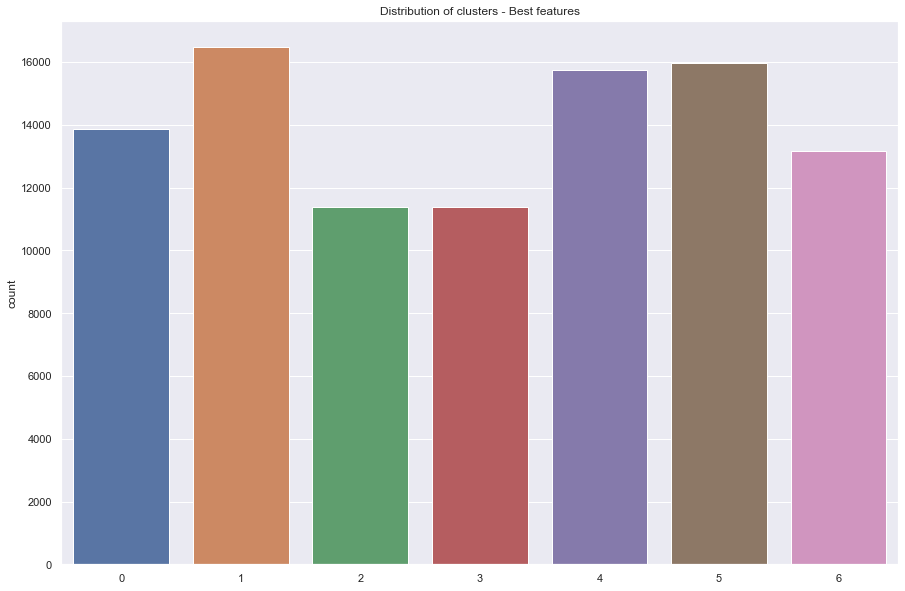

In [14]:
sns.set(rc={'figure.figsize':(15,10)})
pl = sns.countplot(x=predict)
pl.set_title("Distribution of clusters - Best features")
plt.show()

In [15]:
submission['Predicted'] = predict
submission.to_csv('bgm_supervised_classifier_soft_voting.csv', index=False)
submission.head(20)

,Id,Predicted
0,0,0
1,1,2
2,2,4
3,3,6
4,4,1
5,5,1
6,6,6
7,7,0
8,8,2
9,9,5
